# Etapa 00 - Leitura das Bibliotecas utilizadas no projeto

In [36]:
# Análise e tratamento de dados
import pandas as pd
import numpy as np
import json

# Requisição via API
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# Banco de dados
import sqlite3

# Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns

# Séries Temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Regressão Linear
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Etapa 01 - Acessar dados sobre a Receita Municipal

## Requisitar dados do site do Tribunal de Contas do Estado de Pernambuco

In [ ]:
# Obs: etapa inicial, preparatória e necessária para não ter dificuldades com requisições ao site do TCE-PE

session = requests.Session()
retry = Retry(connect=5, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

In [ ]:
# Solicita dados do site do TCE-PE via API
exercicios = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
dicionario = {}
base_dados = []
base_dados_temp = []
for i, ano in enumerate(exercicios):
  url = 'https://sistemas.tce.pe.gov.br/DadosAbertos/ReceitasMunicipais!json?ANOREFERENCIA=%s&ID_UNIDADE_GESTORA=319' % (ano)
  resposta = session.get(url, stream=True)
  if i == 0:
    dicionario = json.loads(resposta.text)
    base_dados = pd.DataFrame.from_dict(data=dicionario['resposta']['conteudo'])
    print('Ano {} concluído.'.format(ano))
    print(f'Ano {ano}: {base_dados.shape[0]} linhas carregadas.')
  else:
    dicionario = json.loads(resposta.text)
    base_dados_temp = pd.DataFrame.from_dict(data=dicionario['resposta']['conteudo'])
    print('Ano {} concluído.'.format(ano))
    print('\n')
    print(f'Ano {ano}: {base_dados_temp.shape[0]} linhas carregadas.')
    base_dados = pd.concat([base_dados, base_dados_temp])
    print(f'Total: {base_dados.shape[0]} linhas carregadas.')
    

Ano 2012 concluído.
Ano 2012: 924 linhas carregadas.
Ano 2013 concluído.


Ano 2013: 972 linhas carregadas.
Total: 1896 linhas carregadas.
Ano 2014 concluído.


Ano 2014: 1011 linhas carregadas.
Total: 2907 linhas carregadas.
Ano 2015 concluído.


Ano 2015: 1248 linhas carregadas.
Total: 4155 linhas carregadas.
Ano 2016 concluído.


Ano 2016: 1376 linhas carregadas.
Total: 5531 linhas carregadas.
Ano 2017 concluído.


Ano 2017: 1305 linhas carregadas.
Total: 6836 linhas carregadas.
Ano 2018 concluído.


Ano 2018: 1347 linhas carregadas.
Total: 8183 linhas carregadas.
Ano 2019 concluído.


Ano 2019: 1428 linhas carregadas.
Total: 9611 linhas carregadas.
Ano 2020 concluído.


Ano 2020: 1892 linhas carregadas.
Total: 11503 linhas carregadas.
Ano 2021 concluído.


Ano 2021: 1902 linhas carregadas.
Total: 13405 linhas carregadas.
Ano 2022 concluído.


Ano 2022: 1001 linhas carregadas.
Total: 14406 linhas carregadas.


## Análise e Tratamento dos dados requisitados

In [ ]:
base_dados.shape

(14406, 12)

In [ ]:
base_dados.columns

Index(['ID_UNIDADE_GESTORA', 'NUMERORECEITAORCAMENTARIAUG', 'DESCRICAO',
       'CATEGORIARECEITA', 'ANOREFERENCIA', 'MESREFERENCIA', 'VALORLANCAMENTO',
       'ESFERA', 'ORIGEMRECEITA', 'DEDUCAORECEITA', 'ESPECIERECEITA',
       'DESCRICAOFONTE'],
      dtype='object')

In [ ]:
base_dados = base_dados.reset_index()

In [ ]:
base_dados = base_dados.drop(labels='index', axis=1)

In [ ]:
base_dados['COMPETENCIA'] = pd.to_datetime({'year': base_dados['ANOREFERENCIA'], 'month': base_dados['MESREFERENCIA'], 'day': 1}, format="%m/%Y")

In [ ]:
base_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14406 entries, 0 to 14405
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_UNIDADE_GESTORA           14406 non-null  object        
 1   NUMERORECEITAORCAMENTARIAUG  14404 non-null  object        
 2   DESCRICAO                    14404 non-null  object        
 3   CATEGORIARECEITA             14406 non-null  object        
 4   ANOREFERENCIA                14406 non-null  object        
 5   MESREFERENCIA                14406 non-null  object        
 6   VALORLANCAMENTO              14406 non-null  object        
 7   ESFERA                       14406 non-null  object        
 8   ORIGEMRECEITA                14404 non-null  object        
 9   DEDUCAORECEITA               14406 non-null  object        
 10  ESPECIERECEITA               13005 non-null  object        
 11  DESCRICAOFONTE               12510 non-nu

In [ ]:
base_dados.head()

,ID_UNIDADE_GESTORA,NUMERORECEITAORCAMENTARIAUG,DESCRICAO,CATEGORIARECEITA,ANOREFERENCIA,MESREFERENCIA,VALORLANCAMENTO,ESFERA,ORIGEMRECEITA,DEDUCAORECEITA,ESPECIERECEITA,DESCRICAOFONTE,COMPETENCIA
0,319,917220101,Dedução de Cota-Parte do ICMS - FUNDEB,Dedução de Receitas,2012,3,-3377520.83,M,Alienação de Bens,9,NaN,NaN,2012-03-01
1,319,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,Dedução de Receitas,2012,3,-1873826.21,M,Alienação de Bens,9,NaN,NaN,2012-03-01
2,319,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,Dedução de Receitas,2012,5,-12653.68,M,Alienação de Bens,9,NaN,NaN,2012-05-01
3,319,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,Dedução de Receitas,2012,6,-177813.32,M,Alienação de Bens,9,NaN,NaN,2012-06-01
4,319,917220101,Dedução de Cota-Parte do ICMS - FUNDEB,Dedução de Receitas,2012,7,-4094020.44,M,Alienação de Bens,9,NaN,NaN,2012-07-01


In [ ]:
# Lista de Receitas e Códigos
receitas_cod = base_dados[['NUMERORECEITAORCAMENTARIAUG', 'DESCRICAO']].drop_duplicates()
receitas_cod.to_csv('receitas_cod.csv', sep=';', index=False)

In [ ]:
base_dados.loc[base_dados['NUMERORECEITAORCAMENTARIAUG'].isnull()]

,ID_UNIDADE_GESTORA,NUMERORECEITAORCAMENTARIAUG,DESCRICAO,CATEGORIARECEITA,ANOREFERENCIA,MESREFERENCIA,VALORLANCAMENTO,ESFERA,ORIGEMRECEITA,DEDUCAORECEITA,ESPECIERECEITA,DESCRICAOFONTE,COMPETENCIA
2925,319,NaN,NaN,Receitas Correntes,2015,11,653831.00,M,NaN,0,NaN,Outras Fontes,2015-11-01
3047,319,NaN,NaN,Receitas Correntes,2015,11,100000.00,M,NaN,0,NaN,Outras Fontes,2015-11-01


In [ ]:
base_dados.drop(base_dados[base_dados['NUMERORECEITAORCAMENTARIAUG'].isnull()].index, inplace=True)

In [ ]:
base_dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14404 entries, 0 to 14405
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_UNIDADE_GESTORA           14404 non-null  object        
 1   NUMERORECEITAORCAMENTARIAUG  14404 non-null  object        
 2   DESCRICAO                    14404 non-null  object        
 3   CATEGORIARECEITA             14404 non-null  object        
 4   ANOREFERENCIA                14404 non-null  object        
 5   MESREFERENCIA                14404 non-null  object        
 6   VALORLANCAMENTO              14404 non-null  object        
 7   ESFERA                       14404 non-null  object        
 8   ORIGEMRECEITA                14404 non-null  object        
 9   DEDUCAORECEITA               14404 non-null  object        
 10  ESPECIERECEITA               13005 non-null  object        
 11  DESCRICAOFONTE               12508 non-nu

In [ ]:
# Transformar numeros em valores flutuantes
base_dados['VALORLANCAMENTO'] = base_dados['VALORLANCAMENTO'].astype(float)
base_dados['NUMERORECEITAORCAMENTARIAUG'] = base_dados['NUMERORECEITAORCAMENTARIAUG'].astype(int)

In [ ]:
# Remover Duplicatas
base_dados.drop_duplicates(subset=['ANOREFERENCIA', 'MESREFERENCIA', 'VALORLANCAMENTO'], inplace=True)

In [ ]:
base_dados.to_csv('/content/base_dados_check.csv')

In [ ]:
base_dados.head(20)

,ID_UNIDADE_GESTORA,NUMERORECEITAORCAMENTARIAUG,DESCRICAO,CATEGORIARECEITA,ANOREFERENCIA,MESREFERENCIA,VALORLANCAMENTO,ESFERA,ORIGEMRECEITA,DEDUCAORECEITA,ESPECIERECEITA,DESCRICAOFONTE,COMPETENCIA
0,319,917220101,Dedução de Cota-Parte do ICMS - FUNDEB,Dedução de Receitas,2012,3,-3377520.83,M,Alienação de Bens,9,NaN,NaN,2012-03-01
1,319,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,Dedução de Receitas,2012,3,-1873826.21,M,Alienação de Bens,9,NaN,NaN,2012-03-01
2,319,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,Dedução de Receitas,2012,5,-12653.68,M,Alienação de Bens,9,NaN,NaN,2012-05-01
3,319,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,Dedução de Receitas,2012,6,-177813.32,M,Alienação de Bens,9,NaN,NaN,2012-06-01
4,319,917220101,Dedução de Cota-Parte do ICMS - FUNDEB,Dedução de Receitas,2012,7,-4094020.44,M,Alienação de Bens,9,NaN,NaN,2012-07-01
5,319,917220104,Dedução de Cota-Parte do IPI sobre Exportação ...,Dedução de Receitas,2012,7,-7296.30,M,Alienação de Bens,9,NaN,NaN,2012-07-01
6,319,917220101,Dedução de Cota-Parte do ICMS - FUNDEB,Dedução de Receitas,2012,8,-1139960.91,M,Alienação de Bens,9,NaN,NaN,2012-08-01
7,319,917220101,Dedução de Cota-Parte do ICMS - FUNDEB,Dedução de Receitas,2012,10,-4318786.69,M,Alienação de Bens,9,NaN,NaN,2012-10-01
8,319,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,Dedução de Receitas,2012,12,-34749.29,M,Alienação de Bens,9,NaN,NaN,2012-12-01
9,319,917230000,Dedução de Transferências dos Municípios,Dedução de Receitas,2012,2,-1405453.08,M,Amortização de Empréstimos,9,NaN,NaN,2012-02-01


In [ ]:
base_dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14389 entries, 0 to 14405
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_UNIDADE_GESTORA           14389 non-null  object        
 1   NUMERORECEITAORCAMENTARIAUG  14389 non-null  int64         
 2   DESCRICAO                    14389 non-null  object        
 3   CATEGORIARECEITA             14389 non-null  object        
 4   ANOREFERENCIA                14389 non-null  object        
 5   MESREFERENCIA                14389 non-null  object        
 6   VALORLANCAMENTO              14389 non-null  float64       
 7   ESFERA                       14389 non-null  object        
 8   ORIGEMRECEITA                14389 non-null  object        
 9   DEDUCAORECEITA               14389 non-null  object        
 10  ESPECIERECEITA               12992 non-null  object        
 11  DESCRICAOFONTE               12493 non-nu

## Gravar dados requisitados em um Banco de Dados

In [ ]:
base_dados_gravar = base_dados[['COMPETENCIA', 'ANOREFERENCIA', 'ORIGEMRECEITA', 'DEDUCAORECEITA', 'NUMERORECEITAORCAMENTARIAUG', 'DESCRICAO', 'VALORLANCAMENTO']]

In [ ]:
base_dados_gravar.head()

,COMPETENCIA,ANOREFERENCIA,ORIGEMRECEITA,DEDUCAORECEITA,NUMERORECEITAORCAMENTARIAUG,DESCRICAO,VALORLANCAMENTO
0,2012-03-01,2012,Alienação de Bens,9,917220101,Dedução de Cota-Parte do ICMS - FUNDEB,-3377520.83
1,2012-03-01,2012,Alienação de Bens,9,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,-1873826.21
2,2012-05-01,2012,Alienação de Bens,9,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,-12653.68
3,2012-06-01,2012,Alienação de Bens,9,917220102,Dedução de Cota-Parte do IPVA - FUNDEB,-177813.32
4,2012-07-01,2012,Alienação de Bens,9,917220101,Dedução de Cota-Parte do ICMS - FUNDEB,-4094020.44


In [ ]:
base_dados_gravar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14389 entries, 0 to 14405
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   COMPETENCIA                  14389 non-null  datetime64[ns]
 1   ANOREFERENCIA                14389 non-null  object        
 2   ORIGEMRECEITA                14389 non-null  object        
 3   DEDUCAORECEITA               14389 non-null  object        
 4   NUMERORECEITAORCAMENTARIAUG  14389 non-null  int64         
 5   DESCRICAO                    14389 non-null  object        
 6   VALORLANCAMENTO              14389 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 899.3+ KB


In [ ]:
base_dados_gravar.loc[base_dados_gravar['ANOREFERENCIA'] == "2022"].to_csv('/content/base_dados_FPM_inicio_check.csv')

In [ ]:
# Transformar data em texto para armazenamento no banco de dados - hipótese de explicação do erro.
base_dados_gravar['COMPETENCIA'] = base_dados_gravar['COMPETENCIA'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Criar conexão
con = sqlite3.connect('baseTransferencias.db')

# Criar cursor
cur = con.cursor()

In [ ]:
#Inserir DE-PARA receitas no banco de dados - Fazer upload do arquivo.
receitas_tratadas = pd.read_csv('/content/receitas_tratadas.csv', sep=';', encoding='ISO-8859–1')

In [ ]:
receitas_tratadas.head()

,NUMERORECEITAORCAMENTARIAUG,DESCRICAO,CLASSIFICACAO_SEREC,DETALHAMENTO
0,917220101,Deducao de Cota-Parte do ICMS - FUNDEB,ICMS,DEDUCAO FUNDEB
1,917220102,Deducao de Cota-Parte do IPVA - FUNDEB,IPVA,DEDUCAO FUNDEB
2,917220104,Deducao de Cota-Parte do IPI sobre Exportacao ...,IPI ExportaCAo,DEDUCAO FUNDEB
3,917230000,Deducao de Transferencias dos Municipios,OUTRAS TRANSFERENCIAS,OUTRAS DEDUCOES
4,917213600,Deducao de Transferencia Financeira do ICMS De...,ICMS DesoneraCAo L.C. Nº 87.96,DEDUCAO FUNDEB


In [ ]:
#Criar tabela auxiliar
cur.execute('''CREATE TABLE receitasDePara
               (numeroReceitaOrcamentariaUG_2 text,
               classificacaoSerec text,
               detalhamento text
               )
               ''')

In [ ]:
#Inserir dados na tabela
receitas_tratadas_normalizadas = receitas_tratadas[['NUMERORECEITAORCAMENTARIAUG',	
                                                    'CLASSIFICACAO_SEREC', 
                                                    'DETALHAMENTO']]
receitas_tratadas_lista = receitas_tratadas_normalizadas.values.tolist()

try:
  cur.executemany("INSERT INTO receitasDePara (numeroReceitaOrcamentariaUG_2, classificacaoSerec, detalhamento) VALUES (?, ?, ?)", receitas_tratadas_lista)
  con.commit()
  print("Dados inseridos com sucesso.")
except Exception as e:
  print(str(e))
  print("Falha na inserção de dados.")
finally:
  pass

Dados inseridos com sucesso.


In [ ]:
#Criar tabela principal
cur.execute('''CREATE TABLE transferencias
               (data text,
               ano text,
               origemReceita text, 
               deducaoReceita text,
               numeroReceitaOrcamentariaUG text,
               descricao text,
               valor real,
               FOREIGN KEY (numeroReceitaOrcamentariaUG) REFERENCES receitaDePara(numeroReceitaOrcamentariaUG_2))
               ''')

In [ ]:
#Inserir dados na tabela
base_dados_lista = base_dados_gravar.values.tolist()

try:
  cur.executemany("INSERT INTO transferencias (data, ano, origemReceita, deducaoReceita, numeroReceitaOrcamentariaUG, descricao, valor) VALUES (?, ?, ?, ?, ?, ?, ?)", base_dados_lista)
  con.commit()
  print("Dados inseridos com sucesso.")
except Exception as e:
  print(str(e))
  print("Falha na inserção de dados.")
finally:
  con.close()

Dados inseridos com sucesso.


# ETAPA 02 - Organização dos dados para Previsão

## Salvar tabelas em variáveis

In [2]:
# Criar nova conexão e consultar tabelas gravadas no Banco de dados 
con = sqlite3.connect('baseTransferencias correto até maio-22.db')
cur = con.cursor()

In [3]:
# Tabela Principal
cur.execute("SELECT * FROM transferencias where data >= '2013-01-01' and ano <= '2021-12-31'")
tabela_principal = cur.fetchall()
tabela_principal = pd.DataFrame(tabela_principal)
tabela_principal.columns = ['COMPETENCIA', 'ANOREFERENCIA', 'ORIGEMRECEITA', 'DEDUCAORECEITA', 'NUMERORECEITAORCAMENTARIAUG', 'DESCRICAO', 'VALORLANCAMENTO']

In [4]:
tabela_principal.columns

Index(['COMPETENCIA', 'ANOREFERENCIA', 'ORIGEMRECEITA', 'DEDUCAORECEITA',
       'NUMERORECEITAORCAMENTARIAUG', 'DESCRICAO', 'VALORLANCAMENTO'],
      dtype='object')

In [5]:
# Tabela Auxiliar
cur.execute("SELECT * FROM receitasDePara")
tabela_auxiliar = cur.fetchall()
tabela_auxiliar = pd.DataFrame(tabela_auxiliar)
tabela_auxiliar.columns = ['NUMERORECEITAORCAMENTARIAUG', 'CLASSIFICACAO_SEREC', 'DETALHAMENTO']

In [6]:
tabela_principal.info() #Quantidade de dados confere

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12404 entries, 0 to 12403
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   COMPETENCIA                  12404 non-null  object 
 1   ANOREFERENCIA                12404 non-null  object 
 2   ORIGEMRECEITA                12404 non-null  object 
 3   DEDUCAORECEITA               12404 non-null  object 
 4   NUMERORECEITAORCAMENTARIAUG  12404 non-null  object 
 5   DESCRICAO                    12404 non-null  object 
 6   VALORLANCAMENTO              12404 non-null  float64
dtypes: float64(1), object(6)
memory usage: 678.5+ KB


In [7]:
tabela_auxiliar

,NUMERORECEITAORCAMENTARIAUG,CLASSIFICACAO_SEREC,DETALHAMENTO
0,917220101,ICMS,DEDUCAO FUNDEB
1,917220102,IPVA,DEDUCAO FUNDEB
2,917220104,IPI ExportaCAo,DEDUCAO FUNDEB
3,917230000,OUTRAS TRANSFERENCIAS,OUTRAS DEDUCOES
4,917213600,ICMS DesoneraCAo L.C. Nº 87.96,DEDUCAO FUNDEB
...,...,...,...
287,17149901,None,None
288,17165011,None,None
289,13110203,None,None
290,17179901,None,None


In [8]:
con.close()

## Juntar tabelas e filtrar apenas Receita com Fundo de Participação dos Municípios

In [9]:
tabela_completa = None
tabela_completa = tabela_principal.merge(tabela_auxiliar, how='inner', on='NUMERORECEITAORCAMENTARIAUG')

In [10]:
tabela_completa.shape

(13555, 9)

In [11]:
tabela_completa.drop_duplicates(inplace=True)

In [12]:
tabela_completa.shape

(12460, 9)

In [13]:
# Filtrar receita FPM
tabela_receita_FPM = tabela_completa.loc[tabela_completa['CLASSIFICACAO_SEREC'] == "FPM"]

In [14]:
tabela_receita_FPM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 3613 to 13489
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   COMPETENCIA                  224 non-null    object 
 1   ANOREFERENCIA                224 non-null    object 
 2   ORIGEMRECEITA                224 non-null    object 
 3   DEDUCAORECEITA               224 non-null    object 
 4   NUMERORECEITAORCAMENTARIAUG  224 non-null    object 
 5   DESCRICAO                    224 non-null    object 
 6   VALORLANCAMENTO              224 non-null    float64
 7   CLASSIFICACAO_SEREC          224 non-null    object 
 8   DETALHAMENTO                 224 non-null    object 
dtypes: float64(1), object(8)
memory usage: 17.5+ KB


In [15]:
# Transformar COMPETENCIA para Datetime
tabela_receita_FPM['COMPETENCIA'] = pd.to_datetime(tabela_receita_FPM['COMPETENCIA'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
tabela_receita_FPM.set_index('COMPETENCIA', inplace=True)

In [17]:
tabela_receita_FPM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 224 entries, 2013-01-01 to 2021-07-01
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ANOREFERENCIA                224 non-null    object 
 1   ORIGEMRECEITA                224 non-null    object 
 2   DEDUCAORECEITA               224 non-null    object 
 3   NUMERORECEITAORCAMENTARIAUG  224 non-null    object 
 4   DESCRICAO                    224 non-null    object 
 5   VALORLANCAMENTO              224 non-null    float64
 6   CLASSIFICACAO_SEREC          224 non-null    object 
 7   DETALHAMENTO                 224 non-null    object 
dtypes: float64(1), object(7)
memory usage: 15.8+ KB


In [18]:
# Resumir dados por Competência (soma Rubricas Orçamentárias FPM Bruto - Dedução FUNDEB FPM)
tabela_receita_FPM = tabela_receita_FPM.resample("M").sum()

In [19]:
tabela_receita_FPM.index

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31',
               ...
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', name='COMPETENCIA', length=108, freq='M')

In [20]:
tabela_receita_FPM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2013-01-31 to 2021-12-31
Freq: M
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VALORLANCAMENTO  108 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [ ]:
# Gerar tabela para validação dos dados em excel
# Checagem já realizada. tabela_receita_FPM.to_csv('/content/tabela_receita_FPM.csv')

# ETAPA 03 - Decomposição da Série Temporal

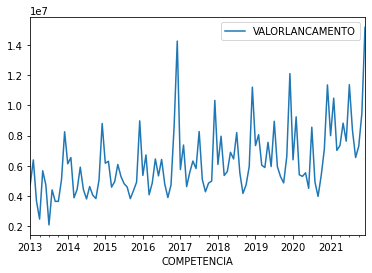

In [21]:
# Visualização da Série Temporal completa
tabela_receita_FPM.plot()

In [22]:
tabela_receita_FPM.describe().round(2)

,VALORLANCAMENTO
count,108.00
mean,6277612.55
std,2277624.40
min,2084897.22
25%,4746750.05
50%,5786661.93
75%,7339479.46
max,15177161.97


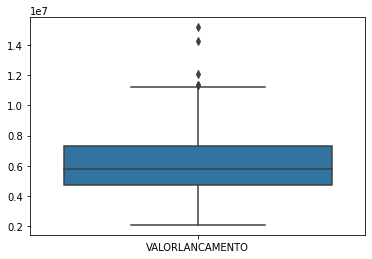

In [23]:
# Outliers
sns.boxplot(data=tabela_receita_FPM)

In [24]:
tabela_receita_FPM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2013-01-31 to 2021-12-31
Freq: M
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VALORLANCAMENTO  108 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [25]:
tabela_receita_FPM.sort_index(inplace=True)

In [33]:
# Decomposição da Série Temporal
# Importante: Precisa-se de toda a série preenchida, sem datas null
# Selecionado o modelo Multiplicativo devido à ocorrência de alteração de amplitude no decorrer da Serie Temporal
resultado_sazonalidade_add = seasonal_decompose(pd.Series(tabela_receita_FPM["VALORLANCAMENTO"]), model="additive")
resultado_sazonalidade_mul = seasonal_decompose(pd.Series(tabela_receita_FPM["VALORLANCAMENTO"]), model="multiplicative")

In [34]:
resultado_sazonalidade_add
resultado_sazonalidade_mul

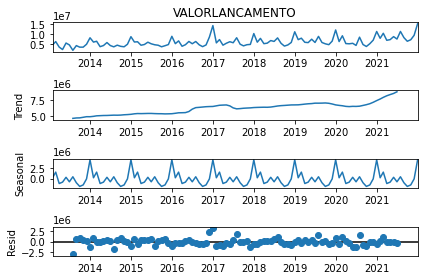

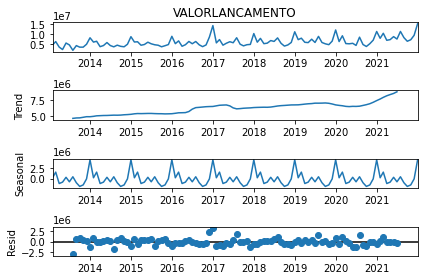

In [35]:
resultado_sazonalidade_add.plot()

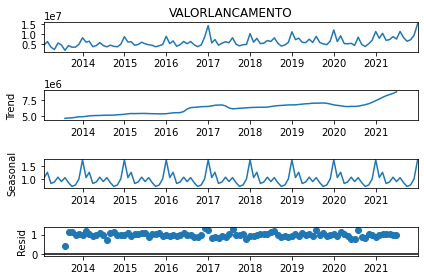

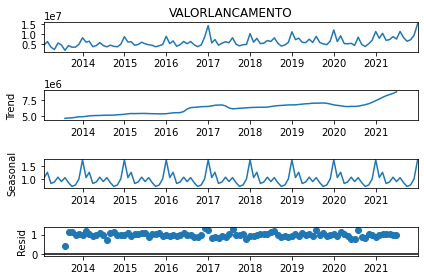

In [32]:
resultado_sazonalidade_mul.plot()

In [ ]:
# Escolhido o modelo Aditivo para decomposição da Série Temporal, haja vista a (aparente) menor variação dos resíduos

# ETAPA 04 - Divisão dos dados (Treino/teste)

In [68]:
N = 12
train = tabela_receita_FPM.iloc[:-N]
test = tabela_receita_FPM.iloc[-N:]

In [69]:
train.head()

,VALORLANCAMENTO,MMS-12,EWM-12,EWM-6,Holt
COMPETENCIA,,,,,
2013-01-31,4749333.07,NaN,4.749333e+06,4.749333e+06,6.389720e+06
2013-02-28,6389719.66,NaN,5.001700e+06,5.218015e+06,7.191128e+06
2013-03-31,3678284.30,NaN,4.798098e+06,4.778092e+06,8.325516e+06
2013-04-30,2470960.73,NaN,4.440077e+06,4.118912e+06,7.445995e+06
2013-05-31,5670894.58,NaN,4.629433e+06,4.562335e+06,6.126518e+06


# ETAPA 05 - Aplicar Modelos de previsão

## Média Móvel Simples

In [70]:
train["MMS-12"] = train["VALORLANCAMENTO"].rolling(12).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


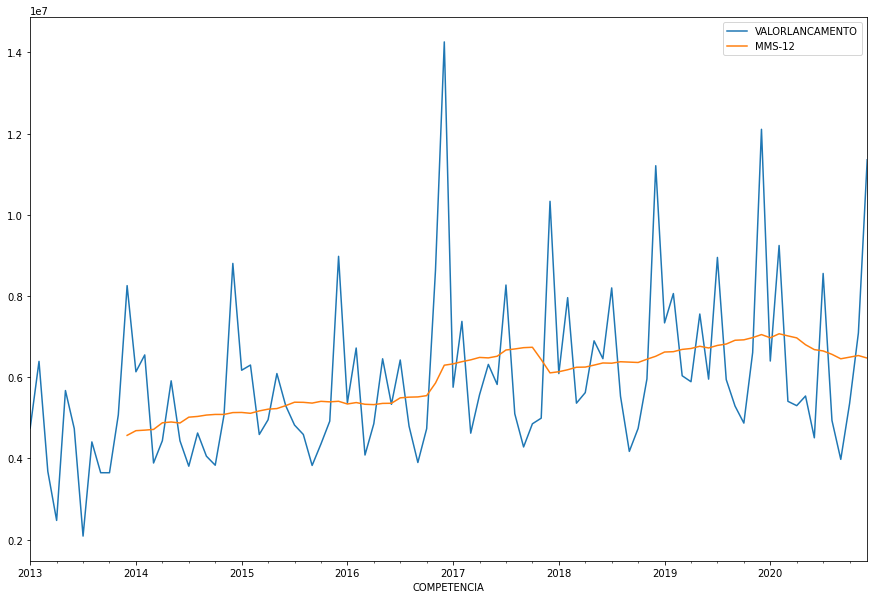

In [72]:
train[["VALORLANCAMENTO", "MMS-12"]].plot(figsize=(15,10))

# Média Móvel Exponencialmente Ponderada

In [73]:
train["EWM-12"] = train["VALORLANCAMENTO"].ewm(span=12, adjust=False).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


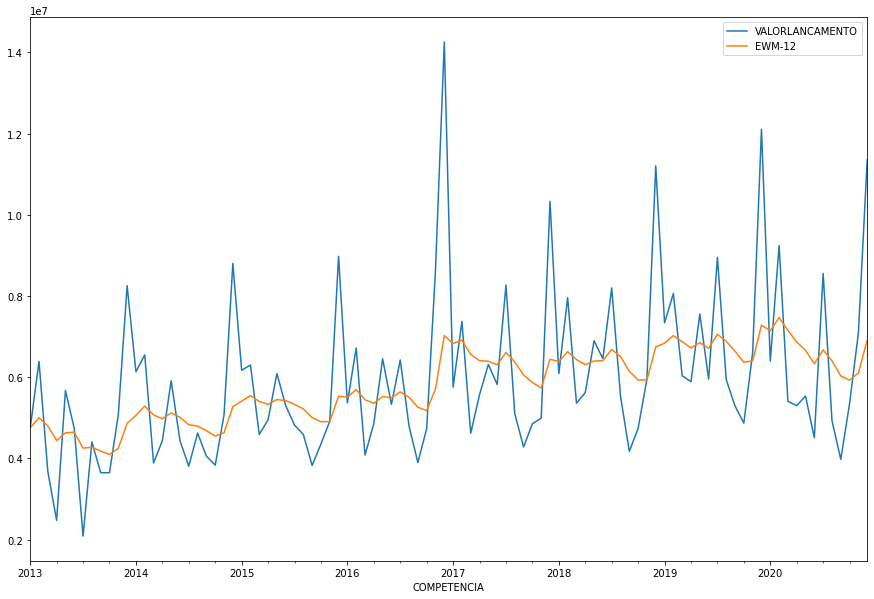

In [74]:
train[["VALORLANCAMENTO", "EWM-12"]].plot(figsize=(15,10))

## Holt

In [75]:
holt = Holt(train["VALORLANCAMENTO"])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [76]:
resultado_holt = holt.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [77]:
train["Holt"] = resultado_holt.fittedvalues

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
test["Holt"] = resultado_holt.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


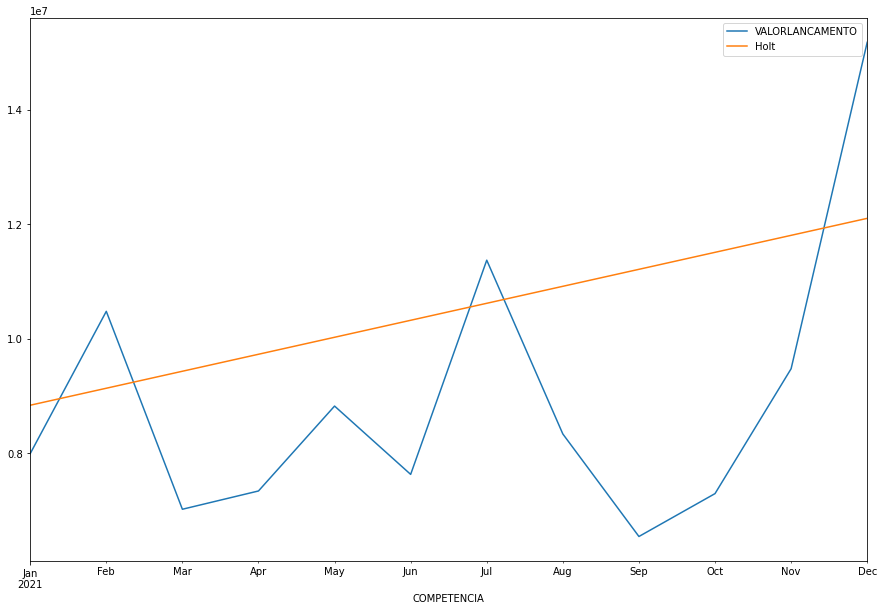

In [79]:
test[["VALORLANCAMENTO", "Holt"]].plot(figsize=(15,10))

## Holt-Winters

In [84]:
holt_winters = ExponentialSmoothing(train['VALORLANCAMENTO'], trend="mul", seasonal="mul", seasonal_periods=12, initialization_method='heuristic')

In [85]:
resultado_hw = holt_winters.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [86]:
train['HW'] = resultado_hw.fittedvalues

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
test['HW'] = resultado_hw.forecast(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


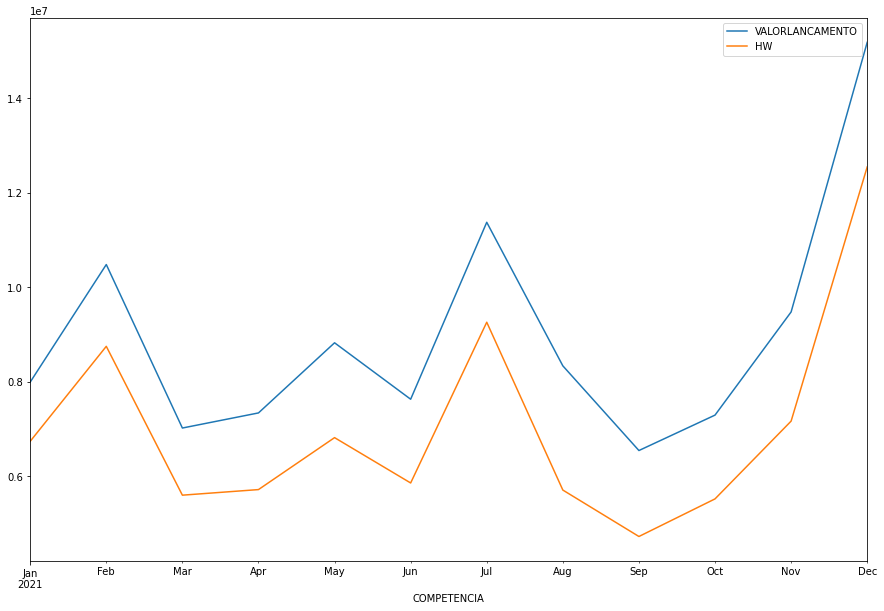

In [89]:
test[["VALORLANCAMENTO", "HW"]].plot(figsize=(15,10))

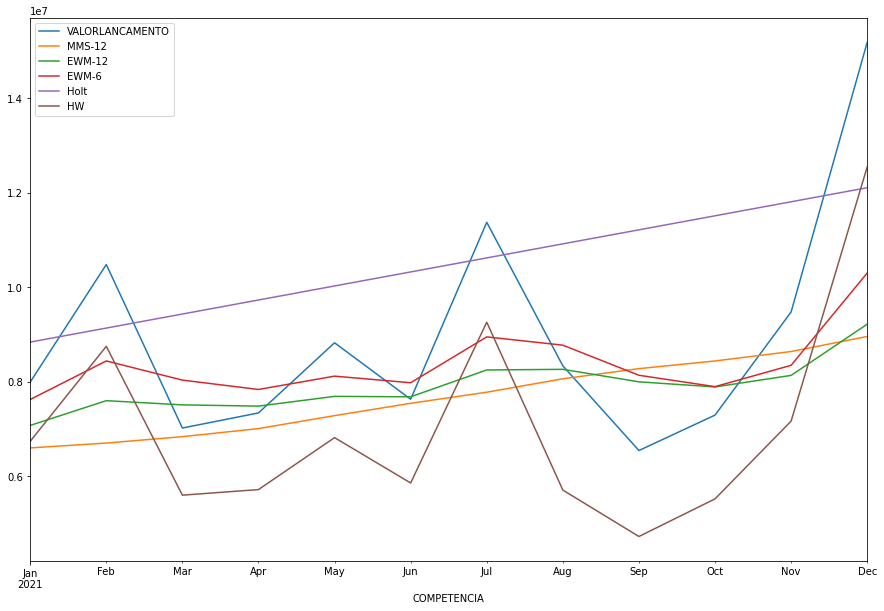

In [91]:
test.plot(figsize=(15,10))